In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from tweedejaars_project import *

In [16]:
""" Data importation and preperation """

df = load_df()
normalized_df=(df-df.mean())/df.std()
normalized_df.dropna(inplace=True)

df.shape

/tmp/ipykernel_18481/2507323582.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  normalized_df=(df-df.mean())/df.std()


(220246, 29)

In [17]:
""" Model creation, compiling and fitting """

feature_list = ['import_capacity',
       'mid_price_published', 'max_price_published', 'minute_in_ptu',
       'settlement_price_bestguess', 'time_since_last_two_sided',
       'two_sided_daily_count', 'vwap_avg',
       'naive_strategy_action', 'forecast_wind',
       'forecast_solar', 'forecast_demand', 'ptu_id']

pca = PCA()
components = pca.fit_transform(df[feature_list])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(len(feature_list)),
    color=df['settlement_price_realized']
)
fig.update_traces(diagonal_visible=True)
fig.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
""" Model creation, compiling and fitting """

feature_list = ['import_capacity',
       'mid_price_published', 'max_price_published', 'minute_in_ptu',
       'settlement_price_bestguess', 'time_since_last_two_sided',
       'two_sided_daily_count', 'vwap_avg',
       'naive_strategy_action', 'forecast_wind',
       'forecast_solar', 'forecast_demand', 'ptu_id']

pca = PCA()
components = pca.fit_transform(normalized_df[feature_list])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(len(feature_list)),
    color=df['target_two_sided_ptu']
)
fig.update_traces(diagonal_visible=True)
fig.show()

ValueError: All arguments should have the same length. The length of argument `color` is 220246, whereas the length of  previously-processed arguments ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'] is 1232

['naive_strategy_action', 'min_ptu_price_known', 'min_price_published', 'forecast_wind', 'time_since_last_two_sided', 'two_sided_daily_count', 'mid_price_published', 'vwap_avg', 'vwap_std', 'vwap_qty_sum', 'minute_in_ptu', 'downward_dispatch_published', 'settlement_price_bestguess', 'import_capacity', 'upward_dispatch_published', 'settlement_price_realized', 'forecast_solar', 'igcc_contribution_down_published', 'vwap_max', 'ptu_id', 'datetime', 'vwap_median', 'PTU', 'hvq_delta', 'forecast_demand', 'max_ptu_price_known', 'igcc_contribution_up_published', 'max_price_published']


<BarContainer object of 28 artists>

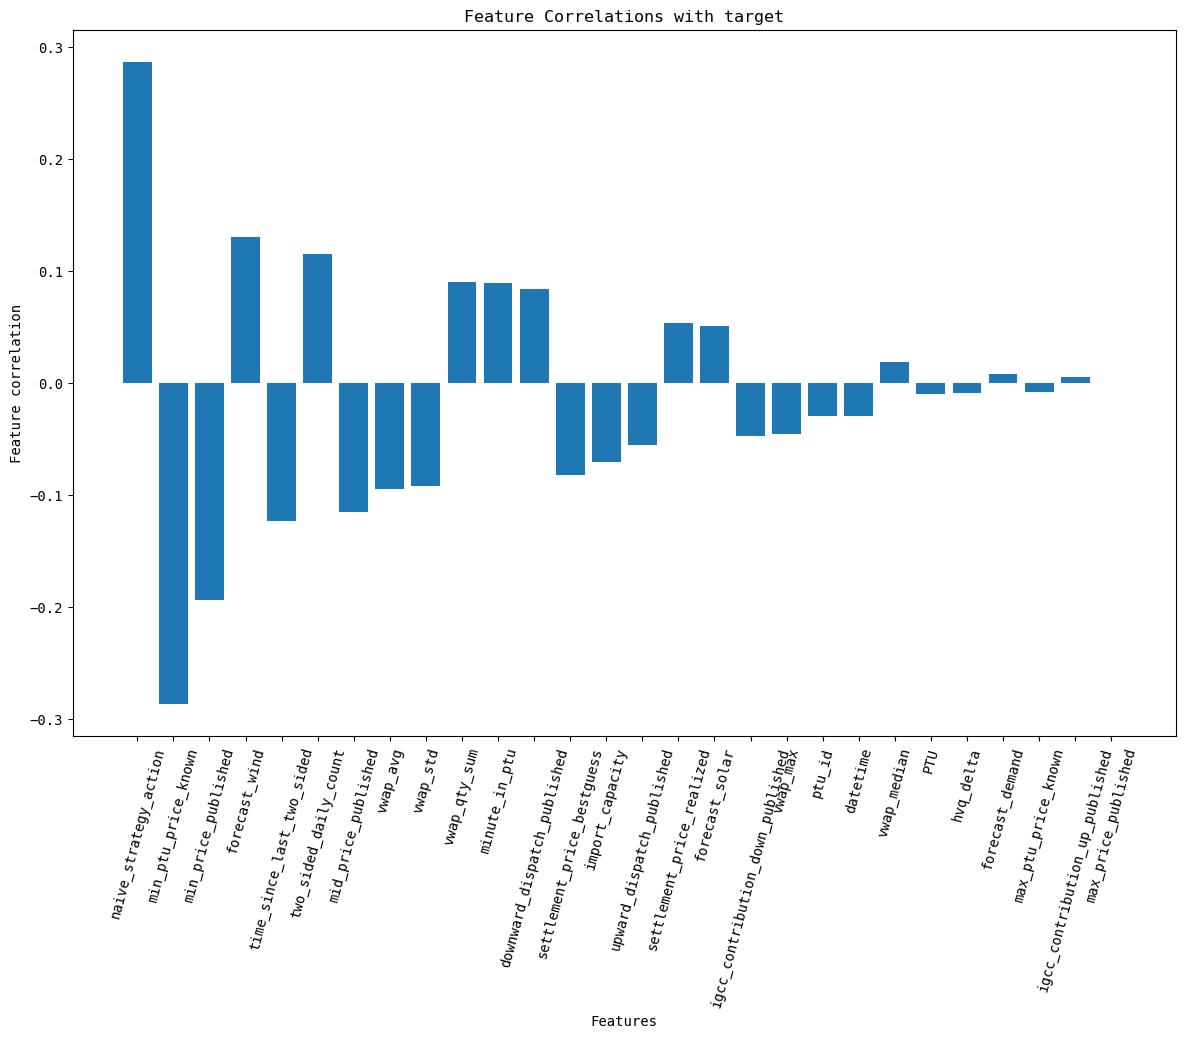

In [ ]:
feature_list = df.columns.drop('target_two_sided_ptu')

corr_ls = []
for feature in feature_list:
    c = df[feature].corr(df['target_two_sided_ptu'])
    corr_ls.append((feature, c))

cor_ls = [(feature, df[feature].corr(df['target_two_sided_ptu'])) for feature in feature_list]
cor_ls.sort(key=lambda x: abs(x[1]), reverse=True)

feature_ls = [x[0] for x in cor_ls]
correlations = [x[1] for x in cor_ls]

print(feature_ls)
plt.figure(figsize=(12, 8))
plt.xlabel('Features')
plt.ylabel('Feature correlation')
plt.title('Feature Correlations with target')
plt.tight_layout()
plt.xticks(rotation=75)
plt.bar(x=feature_ls, height=correlations)

In [19]:
def features(df):
    # forecast
    df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
    df['forecast_solar_delta'] = df['forecast_solar'].diff()
    df['forecast_wind_delta'] = df['forecast_wind'].diff()

    for i in range(0, len(df), 15):
        df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
        df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]

    # diffs
    df['min_price_diff'] = df['min_price_published'].diff() + df['min_price_published']
    df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff() + df['downward_dispatch_published']
    df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff() + df['igcc_contribution_down_published']
    df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
    df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']

    # balance
    df['balance'] = df['residual_load'] # - 

    df['import_zero'] = df['import_capacity'] == 0


    df['import_capacity_left'] = df['import_capacity'] + df['igcc_contribution_down_published'] - df['igcc_contribution_up_published']

    # df['import_capacity_left'] = 0
    # for i in range(1,len(df)):
    #     df.loc[i,'import_capacity_left'] = df['import_capacity_left'][i-1] + df['igcc_contribution_up_published'][i] - df['igcc_contribution_down_published'][i]

    # df.loc[i,'import_capacity_left'] = sum(df['igcc_contribution_up_published'][:i]) - sum(df['igcc_contribution_down_published'][:i])
    return df

['naive_strategy_action', 'min_ptu_price_known', 'min_price_published', 'min_price_diff', 'residual_load', 'balance', 'forecast_wind', 'time_since_last_two_sided', 'two_sided_daily_count', 'mid_price_published', 'import_zero', 'vwap_avg', 'dispatch_diff', 'vwap_std', 'vwap_qty_sum', 'minute_in_ptu', 'downward_dispatch_published', 'settlement_price_bestguess', 'downward_dispatch_diff', 'import_capacity_left', 'import_capacity', 'upward_dispatch_published', 'settlement_price_realized', 'forecast_solar', 'igcc_down_diff', 'igcc_contribution_down_published', 'vwap_max', 'igcc_diff', 'ptu_id', 'datetime', 'forecast_solar_delta', 'vwap_median', 'PTU', 'hvq_delta', 'forecast_demand', 'max_ptu_price_known', 'igcc_contribution_up_published', 'forecast_wind_delta', 'max_price_published']


<BarContainer object of 39 artists>

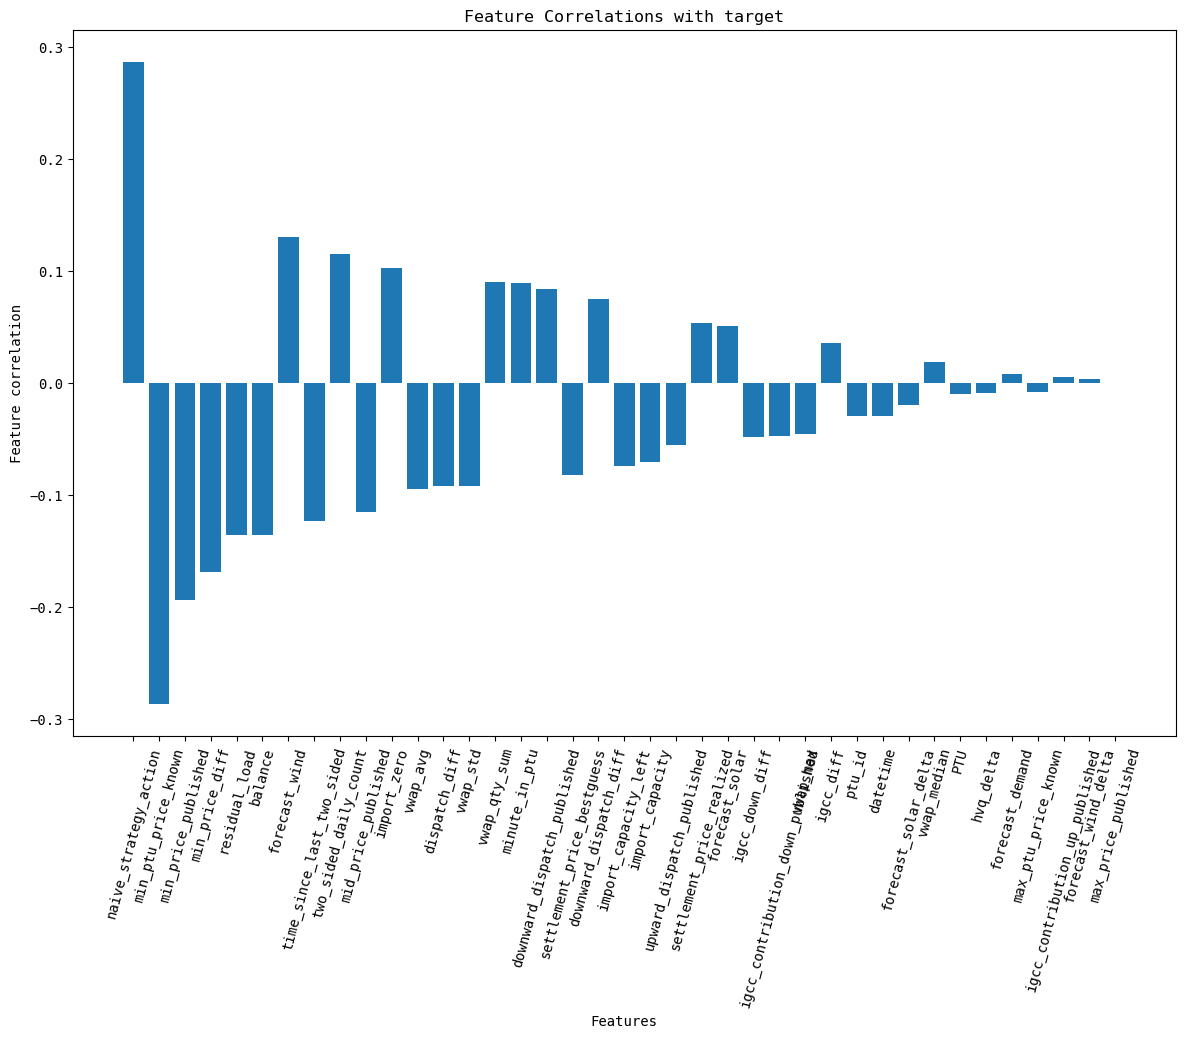

In [20]:
df = features(df)

feature_list = df.columns.drop('target_two_sided_ptu')

corr_ls = []
for feature in feature_list:
    c = df[feature].corr(df['target_two_sided_ptu'])
    corr_ls.append((feature, c))

cor_ls = [(feature, df[feature].corr(df['target_two_sided_ptu'])) for feature in feature_list]
cor_ls.sort(key=lambda x: abs(x[1]), reverse=True)

feature_ls = [x[0] for x in cor_ls]
correlations = [x[1] for x in cor_ls]

print(feature_ls)
plt.figure(figsize=(12, 8))
plt.xlabel('Features')
plt.ylabel('Feature correlation')
plt.title('Feature Correlations with target')
plt.tight_layout()
plt.xticks(rotation=75)
plt.bar(x=feature_ls, height=correlations)